## Lesson 6

In this lesson we will start to explore dynamics at your site of interest by plotting the results from the simulation run in lesson 5. This requires plotting history outputs that are indexed by site, pft, and size. All outputs in FATES are output as one dimensional vectors, meaning we have to untangle them in order to make sense of the simulated dynamics. To do this we make use of the function below. This function takes an output that is in the from 

pft_1_size_1, pft_1_size_2, pft_1_size_3 ... pft_1_maxsize, pft_2_size_1, pft_2_size_2, pft_2_maxsize ... 

and converts to a multi-dimensional array. 

In [1]:
rm(list=ls())

In [2]:
szpf_to_scls_by_pft = function(data, nsize, npft, ntime){
  
  # convert to a vector first
  vec = as.vector(data)
  # now put it into a 3 dimensional array
  arr = array(vec, dim = c(nsize,  npft, ntime))
  return(arr)
  
}

### Libraries 

In [3]:
library(RColorBrewer)
library(ncdf4)
library(fields)

Warning message:
“package ‘RColorBrewer’ was built under R version 4.3.3”
Loading required package: spam

Spam version 2.10-0 (2023-10-23) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridisLite

Warning message:
“package ‘viridisLite’ was built under R version 4.3.3”

Try help(fields) to get started.



#### Make some colours for plotting

In [4]:
cols = brewer.pal(12, 'Paired')
cols_greens = brewer.pal(9, 'Greens')
cols_reds = brewer.pal(9, 'Reds')

In [5]:
# load an example FATES run
fates = nc_open('/pscratch/sd/j/jneedham/elm_runs/fates-tute-runs/bci/fates-tutorial-bci-2pfts.Edf989f750d-Fb8e4eee5.2024-08-09/run/fates-tutorial-bci-2pfts.Edf989f750d-Fb8e4eee5.2024-08-09.sofar.nc')

# Extract some useful variables
lon = ncvar_get(fates, 'lon')
lat = ncvar_get(fates, 'lat')
time = ncvar_get(fates, 'time')/365
sizebins = ncvar_get(fates, 'fates_levscls')
pfts = ncvar_get(fates, 'fates_levpft')

ntime = length(time)
nsize = length(sizebins)
npft = length(pfts)


nyears = ceiling(length(ncvar_get(fates, 'time'))/12)
tave_start = nyears*12 - 2*12 
tave_stop = nyears*12

### Plotting multi-dimensional FATES outputs

As an example let's look at the 'FATES_VEGC_SZPF' output. This is the total aboveground vegetation biomass in live plants in Kg C m-2. The _SZPF ending tells us that it is output along a size by pft dimension. We can use the szpf_to_scls_by_pft function to turn it into an array, rather than a one dimensional output. 

In [6]:
vegc = ncvar_get(fates, 'FATES_VEGC_SZPF')
fillvalue = ncatt_get(fates, 'FATES_VEGC_SZPF', '_FillValue')
vegc[vegc == fillvalue$value] = NA
dim(vegc)

vegc_szpf = szpf_to_scls_by_pft(vegc, nsize, npft, ntime)
dim(vegc_szpf)

vegc_pft = apply(vegc_szpf, MARGIN=c(2,3), FUN=sum) # sum over the size dimension
dim(vegc_pft)

###  Number of plants through time
nplant = ncvar_get(fates, 'FATES_NPLANT_SZPF')
fillvalue = ncatt_get(fates, 'FATES_NPLANT_SZPF', '_FillValue')
nplant[nplant == fillvalue$value] = NA
nplant_szpf = szpf_to_scls_by_pft(nplant, nsize, npft, ntime)
nplant_pft = apply(nplant_szpf, MARGIN=c(2,3), FUN=sum) # sum over the size dimension


[1]  26 279

[1]  13   2 279

[1]   2 279

### Exploring PFT competitive-dynamics

If we plot AGB through time by PFT we can see how PFT dominance changes through time and whether we have coexistence of our PFTs. 
We can also look at the number of stems through time of each PFT. 

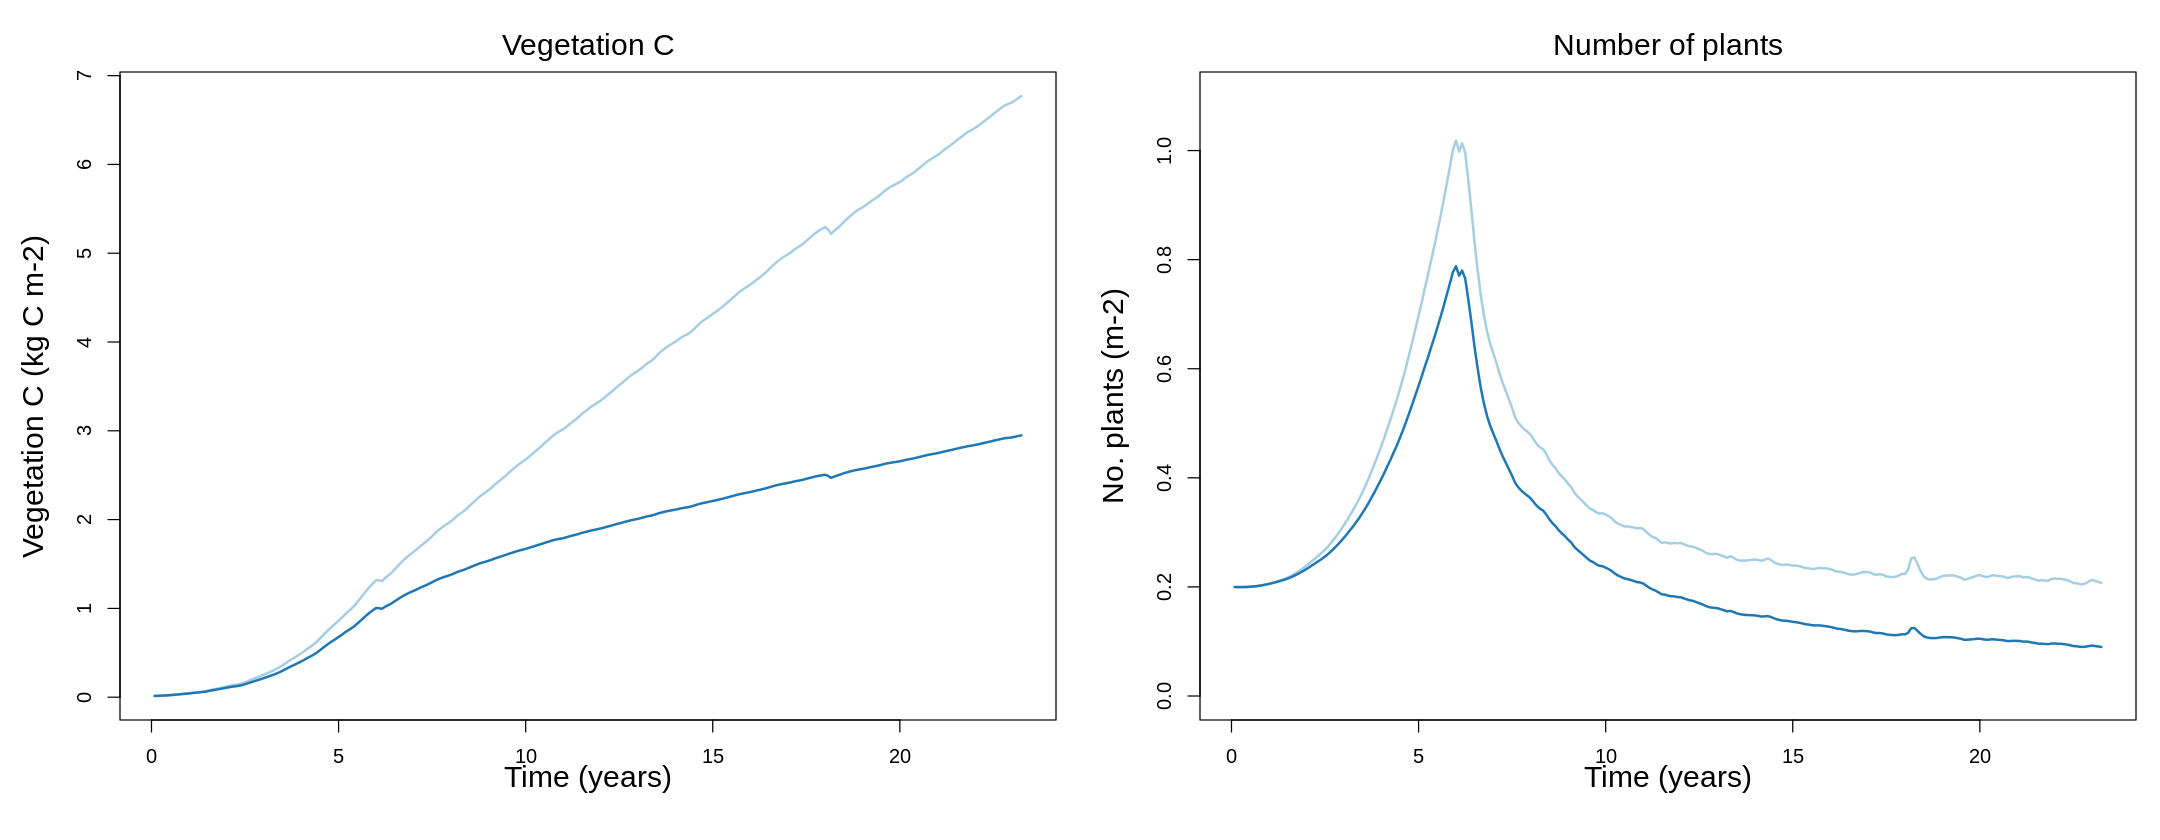

In [7]:
## Fig 1
options(repr.plot.width = 18)

par(mfrow=c(1,2), mar=c(5,5,3,1))


plot(time, vegc_pft[1,], type = 'l', xlab ='', ylab = '',
     lwd = 2, col = cols[1], main = '')
points(time, vegc_pft[2,], type = 'l', xlab ='', ylab = '',
     lwd = 2, col = cols[2], main = '')
mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('Vegetation C (kg C m-2)', side=2, line=3, cex=1.5)
mtext('Vegetation C', side=3, line=0.5, cex=1.5)

### Number of plants through time
plot(time, nplant_pft[1,], type = 'l', xlab ='', ylab = '',
     lwd = 2, col = cols[1], main='', ylim= c(0,1.1))
points(time, nplant_pft[2,], type = 'l', xlab ='', ylab = '',
     lwd = 2, col = cols[2], main = '')
mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('No. plants (m-2)', side=2, line=3, cex=1.5)
mtext('Number of plants', side=3, line=0.5, cex=1.5)


### Growth and mortality rate by pft x canopy layer through time

Looking at the growth and mortality rates of each PFT can give us insight into why one PFT might be out competing the other. 

In [8]:
###  Number of plants through time
nplant_can = ncvar_get(fates, 'FATES_NPLANT_CANOPY_SZPF')
fillvalue = ncatt_get(fates, 'FATES_NPLANT_CANOPY_SZPF', '_FillValue')
nplant_can[nplant_can == fillvalue$value] = NA
nplant_can_szpf = szpf_to_scls_by_pft(nplant_can, nsize, npft, ntime)

nplant_ustory = ncvar_get(fates, 'FATES_NPLANT_USTORY_SZPF')
fillvalue = ncatt_get(fates, 'FATES_NPLANT_USTORY_SZPF', '_FillValue')
nplant_ustory[nplant_can == fillvalue$value] = NA
nplant_ustory_szpf = szpf_to_scls_by_pft(nplant_ustory, nsize, npft, ntime)


### DDBH 
ddbh_can = ncvar_get(fates, 'FATES_DDBH_CANOPY_SZPF') * 100
fillvalue = ncatt_get(fates, 'FATES_DDBH_CANOPY_SZPF', '_FillValue')
ddbh_can[ddbh_can == fillvalue$value] = NA
ddbh_can_szpf = szpf_to_scls_by_pft(ddbh_can, nsize, npft, ntime)

ddbh_ustory = ncvar_get(fates, 'FATES_DDBH_USTORY_SZPF') * 100
fillvalue = ncatt_get(fates, 'FATES_DDBH_USTORY_SZPF', '_FillValue')
ddbh_ustory[ddbh_ustory == fillvalue$value] = NA
ddbh_ustory_szpf = szpf_to_scls_by_pft(ddbh_ustory, nsize, npft, ntime)


### MORTALITY 
mort_can = ncvar_get(fates, 'FATES_MORTALITY_CANOPY_SZPF')
fillvalue = ncatt_get(fates, 'FATES_MORTALITY_CANOPY_SZPF', '_FillValue')
mort_can[mort_can == fillvalue$value] = NA
mort_can_szpf = szpf_to_scls_by_pft(mort_can, nsize, npft, ntime)

mort_ustory = ncvar_get(fates, 'FATES_MORTALITY_USTORY_SZPF')
fillvalue = ncatt_get(fates, 'FATES_MORTALITY_USTORY_SZPF', '_FillValue')
mort_ustory[mort_ustory == fillvalue$value] = NA
mort_ustory_szpf = szpf_to_scls_by_pft(mort_ustory, nsize, npft, ntime)

mort_can_szpf = mort_can_szpf / nplant_can_szpf
mort_ustory_szpf = mort_ustory_szpf / nplant_ustory_szpf
#mort_ustory_szpf[is.na(mort_ustory_szpf)] = 0
mort_ustory_szpf[is.infinite(mort_ustory_szpf)] = 0

ddbh_can_szpf = ddbh_can_szpf / nplant_can_szpf
ddbh_ustory_szpf = ddbh_ustory_szpf / nplant_ustory_szpf

In [9]:
range(mort_can_szpf)

[1] NaN NaN

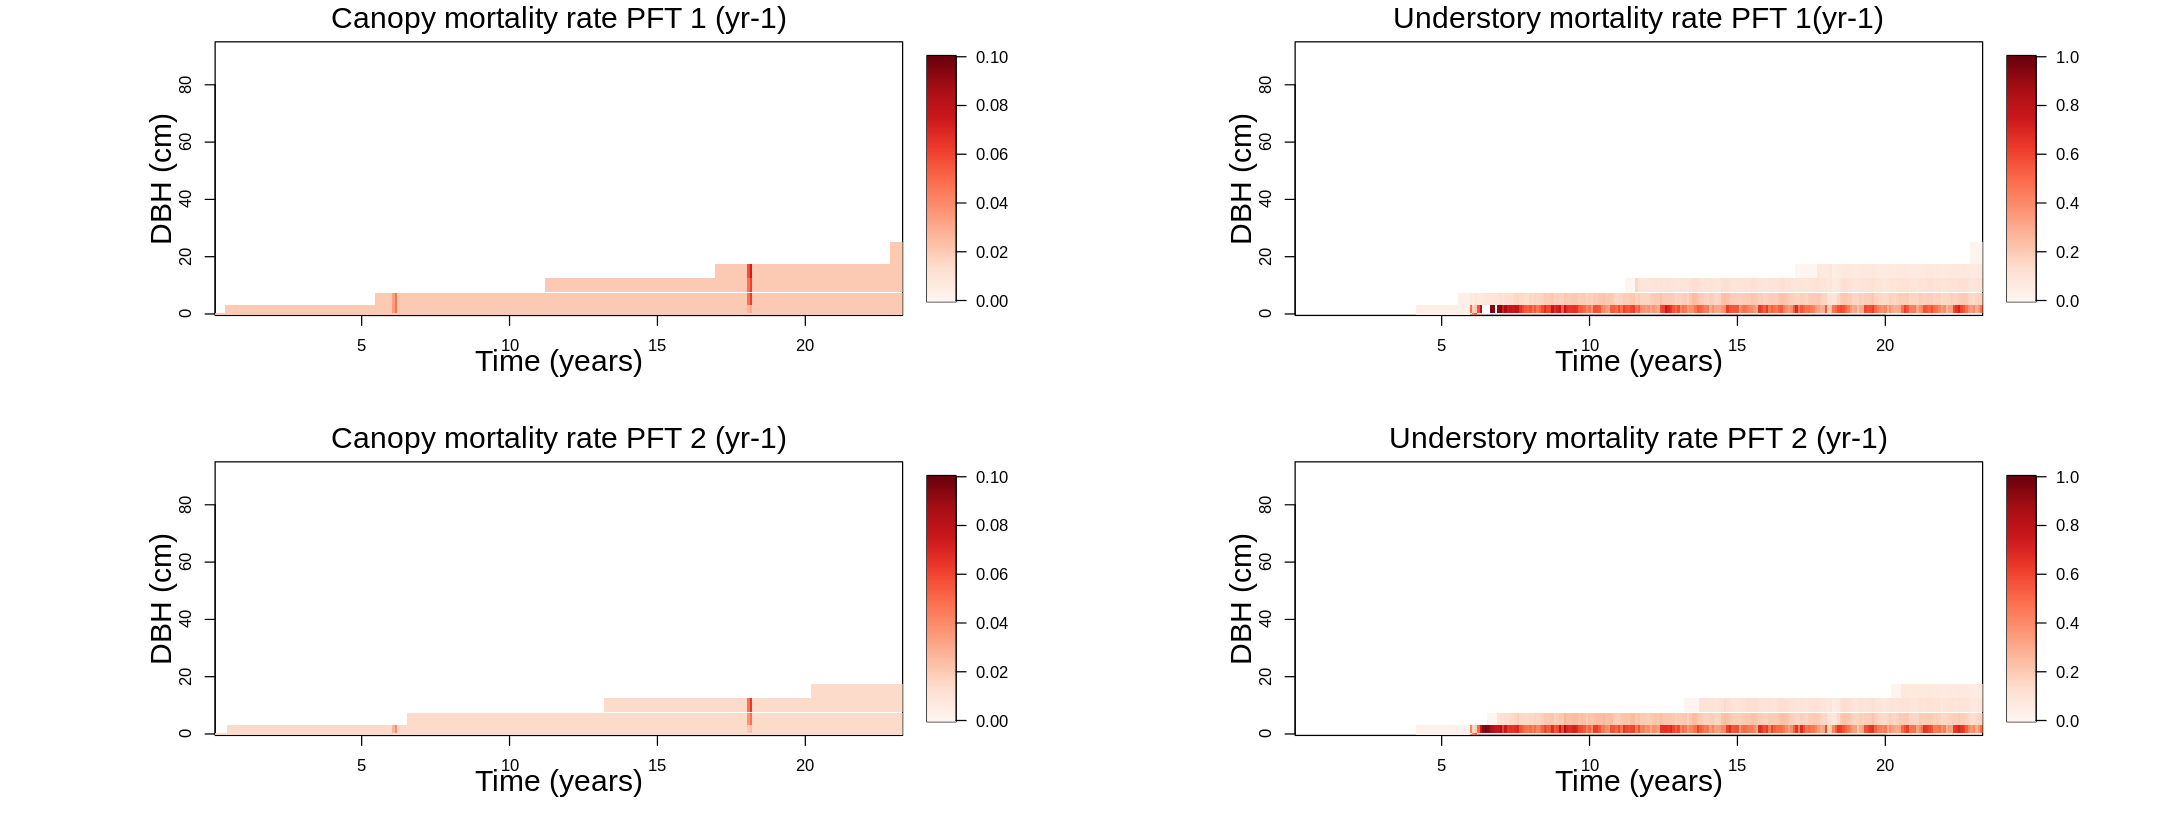

In [10]:
par(mfrow=c(2,2), mar=c(5,4,2,1))

ncolors=100
red_col_pal=colorRampPalette(cols_reds)(ncolors)

# 3. canopy mortality 
image.plot(x=time, y=sizebins, z=t(mort_can_szpf[,1,]), xlab ='', ylab = '',
      main = '', col=red_col_pal, zlim = c(0, 0.1))

mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('DBH (cm)', side=2, line=2, cex=1.5)
mtext('Canopy mortality rate PFT 1 (yr-1)', side=3, line=0.5, cex=1.5)

# Understory mortality 
image.plot(x=time, y=sizebins, z=t(mort_ustory_szpf[,1,]), xlab ='', ylab = '',
      main = '', col=red_col_pal , zlim = c(0, 1))

mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('DBH (cm)', side=2, line=2, cex=1.5)
mtext('Understory mortality rate PFT 1(yr-1)', side=3, line=0.5, cex=1.5)

# canopy 
image.plot(x=time, y=sizebins, z=t(mort_can_szpf[,2,]), xlab ='', ylab = '',
      main = '', col=red_col_pal, zlim = c(0, 0.1))

mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('DBH (cm)', side=2, line=2, cex=1.5)
mtext('Canopy mortality rate PFT 2 (yr-1)', side=3, line=0.5, cex=1.5)

# Understory mortality 
image.plot(x=time, y=sizebins, z=t(mort_ustory_szpf[,2,]), xlab ='', ylab = '',
      main = '', col=red_col_pal, zlim = c(0, 1))

mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('DBH (cm)', side=2, line=2, cex=1.5)
mtext('Understory mortality rate PFT 2 (yr-1)', side=3, line=0.5, cex=1.5)


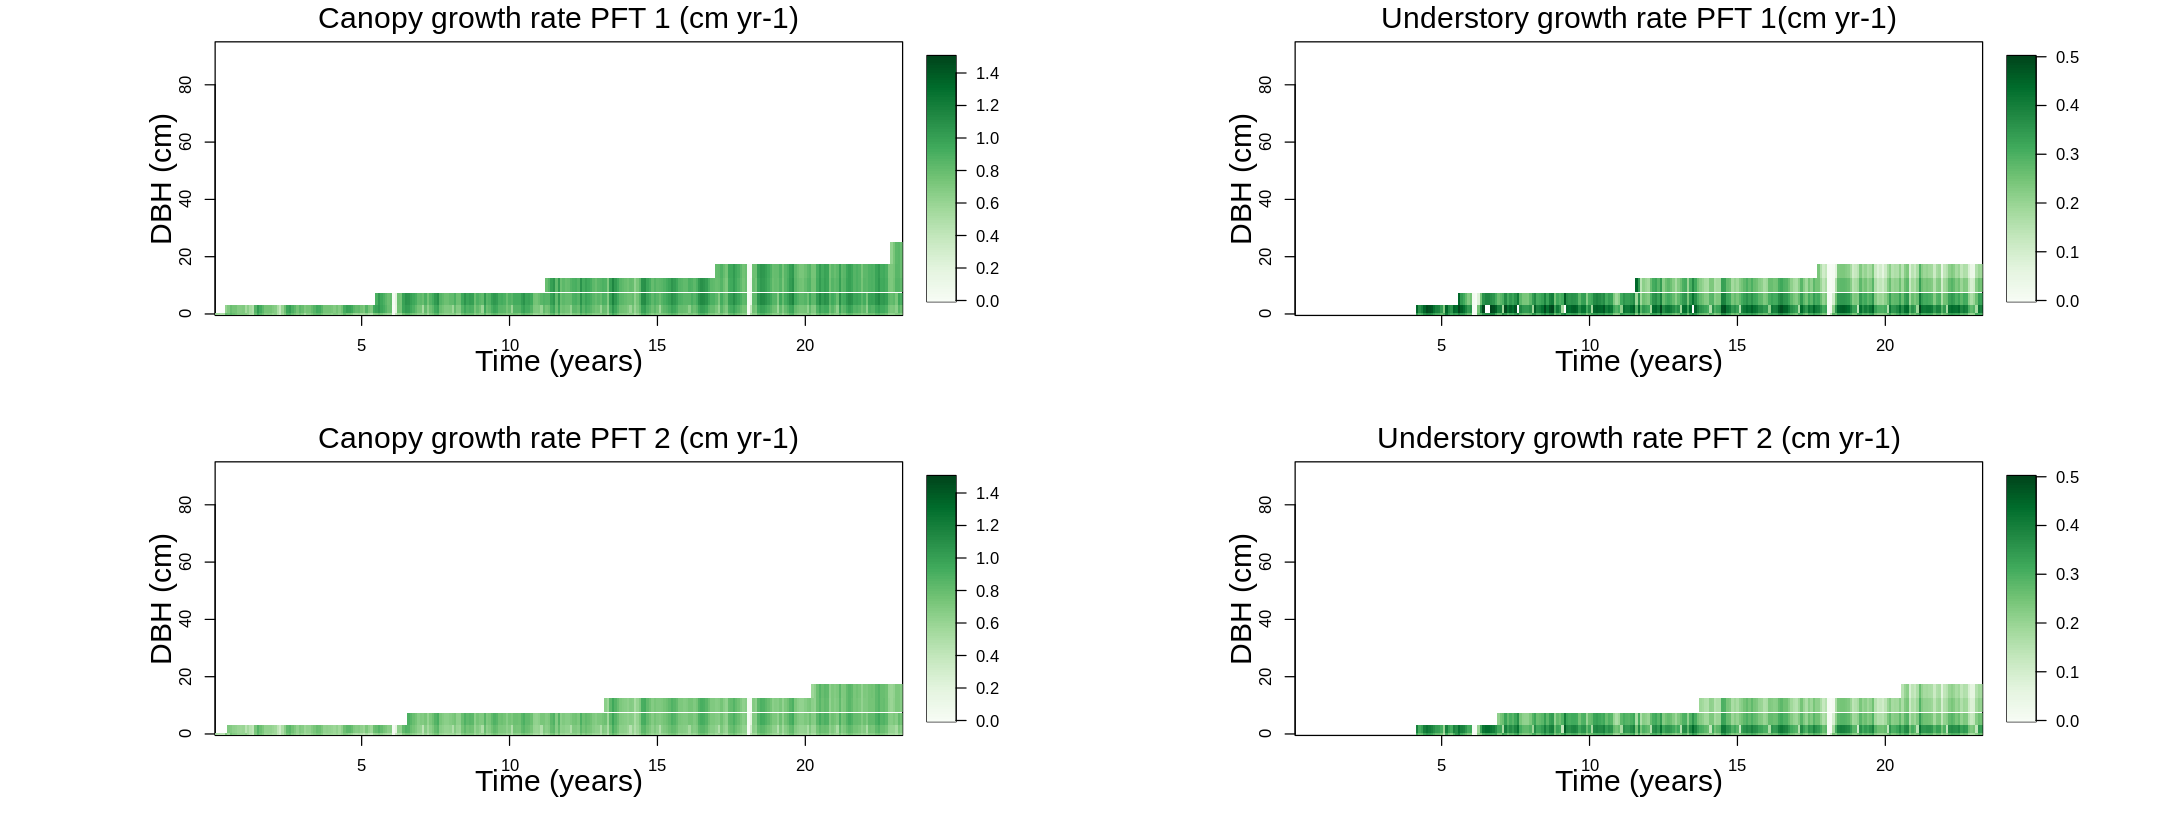

In [11]:
par(mfrow=c(2,2), mar=c(5,4,2,1))

ncolors=100
green_col_pal=colorRampPalette(cols_greens)(ncolors)

# 3. canopy growth
image.plot(x=time, y=sizebins, z=t(ddbh_can_szpf[,1,]), xlab ='', ylab = '',
      main = '', col=green_col_pal, zlim = c(0, 1.5))

mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('DBH (cm)', side=2, line=2, cex=1.5)
mtext('Canopy growth rate PFT 1 (cm yr-1)', side=3, line=0.5, cex=1.5)

# Understory growth
image.plot(x=time, y=sizebins, z=t(ddbh_ustory_szpf[,1,]), xlab ='', ylab = '',
      main = '', col=green_col_pal, zlim = c(0, 0.5))

mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('DBH (cm)', side=2, line=2, cex=1.5)
mtext('Understory growth rate PFT 1(cm yr-1)', side=3, line=0.5, cex=1.5)

# canopy growth
image.plot(x=time, y=sizebins, z=t(ddbh_can_szpf[,2,]), xlab ='', ylab = '',
      main = '', col=green_col_pal, zlim = c(0, 1.5))

mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('DBH (cm)', side=2, line=2, cex=1.5)
mtext('Canopy growth rate PFT 2 (cm yr-1)', side=3, line=0.5, cex=1.5)

# Understory growth
image.plot(x=time, y=sizebins, z=t(ddbh_ustory_szpf[,2,]), xlab ='', ylab = '',
      main = '', col=green_col_pal, zlim = c(0, 0.5))

mtext('Time (years)', side=1, line=2, cex=1.5)
mtext('DBH (cm)', side=2, line=2, cex=1.5)
mtext('Understory growth rate PFT 2 (cm yr-1)', side=3, line=0.5, cex=1.5)
